## Fluxo optico

#### **1 Computando o fluxo optico pela minimização da soma das diferenças**

In [454]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import sys
import time
import glob

 Carregando imagens para testes. A sequência de imagens registram a queda de uma árvore.

In [455]:
prev = cv.imread('../../data/tree/1_tree_fall.png')[:,:,0]
curr = cv.imread('../../data/tree/2_tree_fall.png')[:,:,0]

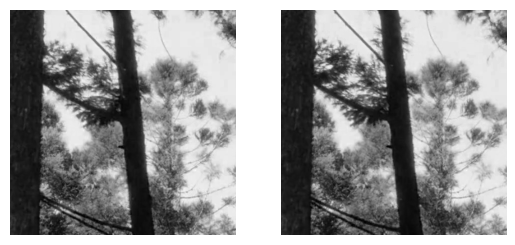

In [456]:
fig, axis = plt.subplots(1,2)
axis[0].imshow(prev, cmap='gray')
axis[1].imshow(curr, cmap='gray')
axis[0].axis('off');
axis[1].axis('off');

A ideia desse algoritmo é bem óbvia: computar uma medida de distância entre as duas imagens em todos os possíveis sentidos de disparidades, ou seja, trata-se de uma busca exaustiva por uma vetor `h` em `I`, que representa a translação de uma imagem `I` para `J`. Se a variação de movimento na cena for pequena, é possível restringir o espaço de busca para alguns pixels na redondeza de `h` em `J`.

Essa técnica também é conhecida como **Registro de Imagem**.

##### O algoritmo

1. Escolhemos uma janela pequena de tamanho `n x n` em `I` e uma janela de busca `h'` de tamanho `n+dx x n+dy` em `J`.
2. Inicia-se a procura em `[dx, dy]` de modo que a janela escolhida ficará no centro da região de busca
3. Computa-se então uma medida de distância entre `h` e `h'`. Isso é feito através da convolução 2D entre a janela e a região de busca.
4. A posição da matriz de distâncias `R` cujo valor for mínimo (ou máximo, se for usada a medida de similaridade), representa a sobreposição da imagem no instante de tempo `t` na imagem do instante `t+1`
5. Assume-se que o deslocamento em `(x, y)` de `h` em `h'` na coordenada dos pixels de `J`, representa o vetor de movimento em um determinado passo.
6. Incrementa-se o passo e repete a partir de `2.` até que tenha-se processado complemente `distancias(J, I)`

In [457]:
def computeImageRegistration(prev, curr):
    img_shape = prev.shape
    img_len = img_shape[0]
    square_size = 50
    search_size = 20
    step = 4
    result = np.zeros((*prev.shape,2))

    for j in range(0, img_len, step):
        for i in range(0, img_len, step):

            pad = search_size
            template = prev[j+pad:j+pad+square_size,i+pad:i+pad+square_size]
            patch = curr[j:j+pad*2+square_size,i:i+pad*2+square_size]

            w, h = template.shape[::-1]
            if w == 0 or h == 0: continue

            # pequena trapaca para evitar codificar a convolucao :v
            res = cv.matchTemplate(patch, template, cv.TM_CCOEFF_NORMED)
            min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
            if (max_val < 0.98): continue

            flow = ((pad - max_loc[1]), (pad - max_loc[0]))
            result[i:i+step, j:j+step] = flow
            
    return result

O resultado desse algoritmo é uma matriz `U` com `N` vetores `2 x 1` que representam a direção do movimento `(u, v)` naquela posição.
Para visualizar esses vetores, fazemos a distribuição em uma malha igualmente espaçada. Desenha-se uma linha com módulo e sentido determinados por `(u, v)` para cada ponto dessa malha.

In [458]:
def drawFlow(img, flow, step=16, color=(0, 255, 0)):
    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fy, fx = flow[x,y].T
    lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)
    vis = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    cv.polylines(vis, lines, 0, color)
    for (x1, y1), (_x2, _y2) in lines:
        cv.circle(vis, (x1, y1), 1, color, -1)
    return vis

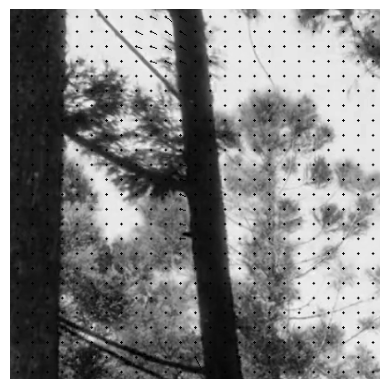

In [459]:
flow = computeImageRegistration(prev, curr)
vis = drawFlow(curr, flow, step=16)[:,:,0]
plt.imshow(vis, cmap='gray')
plt.axis('off');

É possível notar que o método foi capaz de computar um pequeno deslocamento do tronco da direita para a esqueda (sentido -x, na coordenada da imagem). Esse movimento foi mais significativo na parte superior da imagem. 

#### **2 Computando o fluxo óptico por Lucas-Kanade**

O algoritmo a seguir é uma implementação ingênua do método de Lucas-Kanade [[1]](https://cseweb.ucsd.edu/classes/sp02/cse252/lucaskanade81.pdf)

O método proposto pelos autores define a ordem dos possíveis `h`s dentro do espaço de busca `h'`. Primeiro é dada uma estimação inicial de `h` e calcula-se o gradiente espacial de intensidade dos pixels em cada ponto da imagem de modo a obter um novo `h` que produz a melhor correspondência na janela de busca.

O algoritmo desenvolvido, no entanto, realiza a busca exaustiva assim como no método das minimização das diferenças. Mas dessa vez usando o gradiente espacial de intensidade para estimar o movimento.

Utilizou-se o kernel de Sobel para computar uma aproximação das derivadas espaciais na direção vertical e horizontal. A derivada no tempo foi computada a partir do filtro da média.

##### O algoritmo
1. Inicia `h` e `h'` de tamanho `n x n`.
2. Computa-se as derivadas `Ix`, `Iy` e `It`, que representam a variação de intensidade de luz nas direções `x`, `y` e `t`.
3. Calcula a matriz `A` de tamanho `n² x 2` a partir de `Ix` e `Iy`, cada coluna representa o gradiente da intensidade em uma direção (`x, y`)
4. Calcula a matriz `B` de tamanho `n x 2` que representa o gradiente da intensidade de cada componente (`x, y`) no tempo
5. Computa-se o vetor das diferenças resolvendo o sistema linear `Au = B`. `u` representa a variação de movimento para esse passo, definimos que este é igual para todos os pixels em `h`.
6. Incrementa o passo em `n` e volta para `2.`

In [460]:
def convolve(image, kernel):
	(iH, iW) = image.shape[:2]
	(kH, kW) = kernel.shape[:2]
	pad = (kW - 1) // 2

	image = cv.copyMakeBorder(image, pad, pad, pad, pad, cv.BORDER_REPLICATE)
	output = np.zeros((iH, iW), dtype="float32")

	for y in np.arange(pad, iH + pad):
		for x in np.arange(pad, iW + pad):
			roi = image[y - pad:y + pad + 1, x - pad:x + pad + 1]
			k = (roi * kernel).sum()
			output[y - pad, x - pad] = k

	return output.flatten()

def computePartialDerivatives(patch : np.ndarray):
    kernel_x = np.array([
        [-1, 0, 1], 
        [-2, 0, 2], 
        [-1, 0, 1]
    ])
    kernel_y = np.array([
        [-1, -2, -1], 
        [0, 0, 0], 
        [1, 2, 1]
    ])
    kernel_t = np.ones((3, 3)) * (1/9)

    # gx = convolve(patch, kernel_x)
    # gy = convolve(patch, kernel_y)
    # gt = convolve(patch, kernel_t)

    # pois a convolucao em python eh 1e6 de vezes mais lenta
    gx = np.convolve(patch.flatten(), kernel_x.flatten())
    gy = np.convolve(patch.flatten(), kernel_y.flatten())
    gt = np.convolve(patch.flatten(), kernel_t.flatten())
    return gx, gy, gt
    
def computeLKDenseFlow(prev_img, curr_img):
    img_shape = prev_img.shape
    square_size = 16
    img_len = img_shape[0]
    result = np.zeros((prev_img.shape[0], prev_img.shape[1], 2))

    for j in range(0, img_len, square_size):
        for i in range(0, img_len, square_size):
            flow = np.array([0, 0])

            prev_patch = prev_img[j:j+square_size,i:i+square_size]
            curr_patch = curr_img[j:j+square_size,i:i+square_size]

            g0_x, g0_y, g0_t = computePartialDerivatives(prev_patch)
            g1_x, g1_y, g1_t = computePartialDerivatives(curr_patch)

            grad_x = g1_x + g0_x
            grad_y = g1_y + g0_y
            grad_t = g1_t - g0_t

            A = np.array([grad_x, grad_y]).T
            B = np.array([-grad_t]).T.flatten()
            ATA = A.T @ A

            eps = 1e-12
            eig_x = np.linalg.norm(ATA[0])
            eig_y = np.linalg.norm(ATA[1])
            if eig_x < eps or eig_y < eps: continue

            if (np.linalg.det(ATA)) > eps:
                flow = np.linalg.inv(ATA) @ (A.T @ B)
            result[i:i+square_size,j:j+square_size] = np.array([flow[0]*1e3, flow[1]*1e3])

    return result

O resultado desse algoritmo pode ser visualizado da mesma maneira que o método anterior.

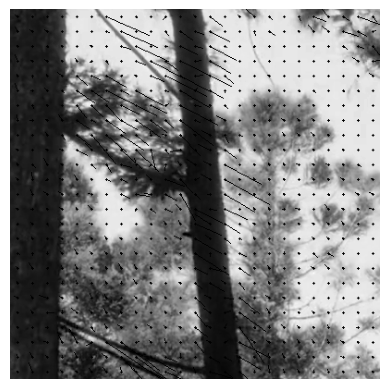

In [461]:
flow = computeLKDenseFlow(prev, curr)
vis = drawFlow(curr, flow, step=16)[:,:,0]
plt.imshow(vis, cmap='gray')
plt.axis('off');

O movimento produzido pela árvore foi melhor representado pelo fluxo otico resultante do gradiente de intensidade em vez da minimização das diferenças.

In [462]:
time_lk_1 = time.time(); computeLKDenseFlow(prev, curr); time_lk_2 = time.time()
time_diff_1 = time.time(); computeImageRegistration(prev, curr); time_diff_2 = time.time()
print(f"Tempo metodo das diferenças = {time_diff_2 - time_diff_1:.4f}")
print(f"Tempo metodo de Lucas-Kanade = {time_lk_2 - time_lk_1:.4f}")

Tempo metodo das diferenças = 1.0509
Tempo metodo de Lucas-Kanade = 0.1510


Notou-se que, apesar de ter sido implementada a versão simplificada do método de Lucas-Kanade, os resultados foram visivelmente melhores e o custo computacional significativamente menor.

##### **3 Kanade-Lucas-Tomasi**

Para o desenvolvimento do sensor de odometria, utilizou-se o método robusto Kanade-Lucas-Tomasi. Esse método, ou sequência de métodos, consiste em, dado um `h` inicial, computar a melhor estimação para a variação de `h` pelo gradiente de intensidade de luz. De acordo com os autores, quanto melhor o `h` inicial, mais rápido o método irá convergir em uma solução útil. 

Como visto na literatura [[2]](https://www.cs.ucf.edu/courses/cap6411/cap6411/spring2006/shi_tomasi_94.pdf), um bom candidato para `h` inicial é um ponto que carrega grande variação de intensidade luminosa. Harris e Stephens propuseram um método para detecção de cantos em imagens baseado na intersecção entre duas bordas, mais tarde, em 1994, Tomasi e Shi fizeram uma modificação no método inicial que gerou melhores resultados.

O algoritmo proposto consiste em:
1. Computar uma estimação inicial para o fluxo optico a partir dos cantos de Shi-Tomasi
2. Registrar a variação de movimento nos pontos iniciais pelo método do gradiente de Lucas-Kanade
3. Computar uma transformação geométrica a partir do casamento dos pontos entre a imagem `I` em `k` e `J` em `k+1`
4. Transformar o vetor `u` que representa a velocidade dos pixels, para a coordenada relativa ao movimento da camera
5. Filtrar discrepâncias na variação do movimento
6. Integrar a velocidade, produzindo deslocamento linear

A seguir, faremos uma investigação do método robusto de estimação do fluxo optico.

In [463]:
def computeKLTOpticalFlow(prev, curr, p0=None):
    # prev_gray = cv.cvtColor(prev,cv.COLOR_BGR2GRAY)
    # curr_gray = cv.cvtColor(curr,cv.COLOR_BGR2GRAY)
    prev_gray = prev
    curr_gray = curr
    
    lk_params = dict( 
        winSize = (15, 15),
        maxLevel = 2,
        criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03)
    )
    
    feature_params = dict( 
        maxCorners = 100,
        qualityLevel = 0.3,
        minDistance = 7,
        blockSize = 7 
    )
    
    if p0 is None:
        p0 = cv.goodFeaturesToTrack(prev_gray, mask = None, **feature_params)
    p1, st, err = cv.calcOpticalFlowPyrLK(prev_gray, curr_gray, p0, None, **lk_params)
    
    if p1 is not None:
        good_new = p1[st==1]
        good_old = p0[st==1]
    
    return good_old, good_new

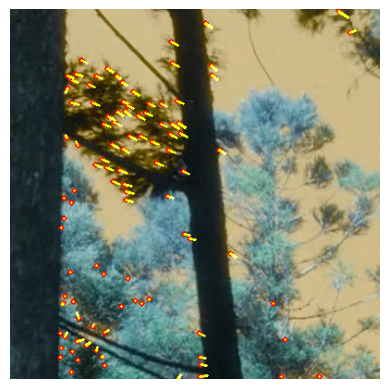

In [465]:
prev = cv.imread('../../data/tree/1_tree_fall.png')
curr = cv.imread('../../data/tree/2_tree_fall.png')

prev_gray = cv.cvtColor(prev,cv.COLOR_BGR2GRAY)
curr_gray = cv.cvtColor(curr,cv.COLOR_BGR2GRAY)

p0, p1 = computeKLTOpticalFlow(prev_gray, curr_gray)
mask = np.zeros_like(prev)

for i, (new, old) in enumerate(zip(p1, p0)):
    a, b = new.ravel()
    c, d = old.ravel()
    mask = cv.line(mask, (int(a), int(b)), (int(c), int(d)), (255, 255, 0), 2)
    frame = cv.circle(curr, (int(a), int(b)), 1, (255, 0, 0), 3)
    img = cv.add(frame, mask)

plt.imshow(img, cmap='gray')
plt.axis('off');

Percebe-se, na imagem acima, que o fluxo optico não foi computado em toda imagem, apenas nas regiões que apresentaram grande variação de intensidade de luz em todas as direções.

In [466]:
time_klt_1 = time.time(); computeLKDenseFlow(prev, curr); time_klt_2 = time.time()
print(f"Tempo metodo KLT = {time_klt_2 - time_klt_1}")

Tempo metodo KLT = 0.16304564476013184


##### Analisando a inicialização do Lucas-Kanade

A robustez do método de Lucas-Kanade depende da inicialização. Um bom candidato para inicialização são pontos na imagem que podem ser facilmente distinguídos na próxima cena. Esses pontos de interesses são comumente chamados de cantos. Os cantos mais utilizados na literatura em conjunto com o LK são os cantos FAST, SIFT, os cantos de Harris e os cantos de Shi-Tomasi.

A seguir faremos uma investigação sobre as características de alguns deles. Para essa análise, utilizarems capturas aéreas sucessivas de uma superfície texturizada, simulando o sobrevoo de um drone que, de maneira rasa e em movimento linear, registra o chão de asfalto sintético.

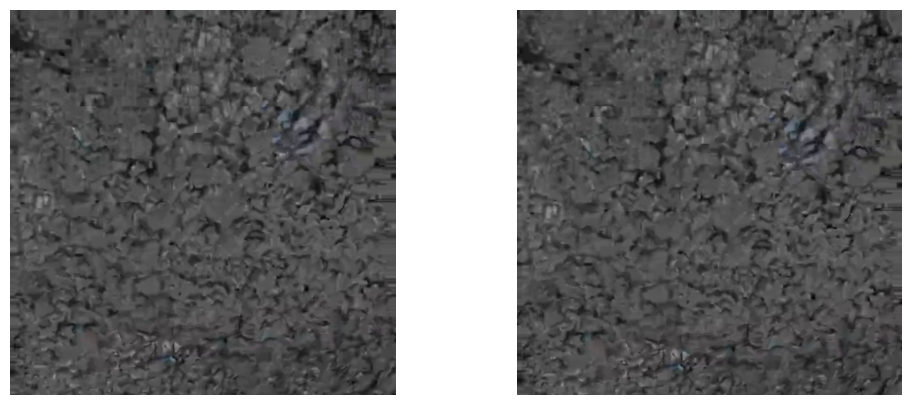

In [467]:
drone_prev = cv.imread('../../data/drone_footage_synthetic_ground/1/frame00096.png')
drone_curr = cv.imread('../../data/drone_footage_synthetic_ground/1/frame00097.png')

drone_prev_gray = cv.cvtColor(drone_prev,cv.COLOR_BGR2GRAY)
drone_curr_gray = cv.cvtColor(drone_curr,cv.COLOR_BGR2GRAY)

fig, axis = plt.subplots(1,2, figsize=(12, 5))
axis[0].imshow(drone_prev, cmap='gray')
axis[1].imshow(drone_curr, cmap='gray')
axis[0].axis('off');
axis[1].axis('off');

##### Distribuição do fluxo optico pelo método das diferenças

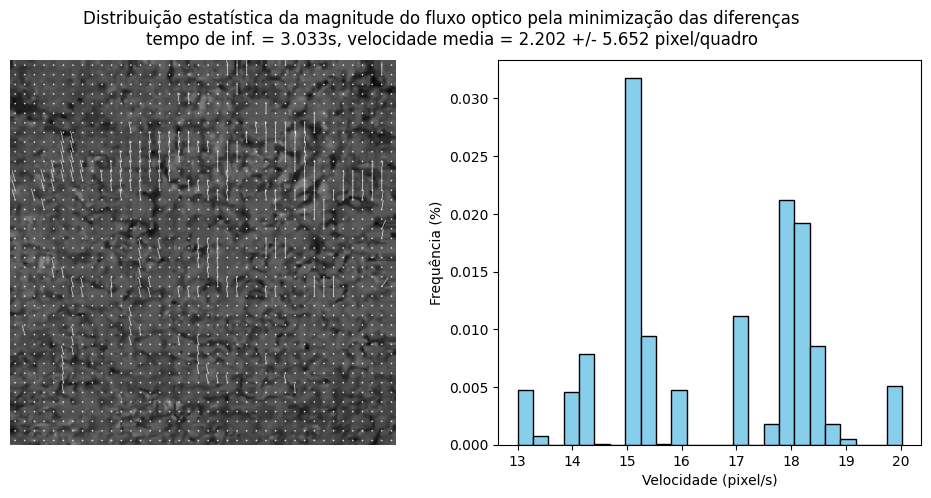

In [468]:
drone_prev = cv.imread('../../data/drone_footage_synthetic_ground/1/frame00096.png')
drone_curr = cv.imread('../../data/drone_footage_synthetic_ground/1/frame00097.png')

drone_prev_gray = cv.cvtColor(drone_prev,cv.COLOR_BGR2GRAY)
drone_curr_gray = cv.cvtColor(drone_curr,cv.COLOR_BGR2GRAY)

t1 = time.time();
flow = computeImageRegistration(drone_prev_gray, drone_curr_gray)
t2 = time.time();

vis = drawFlow(drone_curr_gray, flow, step=16, color=(255,255,0))[:,:,0]
magnitude, _ = cv.cartToPolar(flow[..., 0], flow[..., 1])

mean_magnitude = np.mean(magnitude)
std_dev = np.std(magnitude)

distances, edges = np.histogram(magnitude[magnitude > 0], bins=25)
distances = distances / (drone_prev_gray.shape[0]*drone_prev_gray.shape[1])

fig, axis = plt.subplots(1, 2, figsize=(12, 5))
axis[0].imshow(vis, cmap='gray')
axis[0].axis('off');
axis[1].bar(edges[:-1], distances, width=np.diff(edges), align='edge', color='skyblue', edgecolor='black');
fig.suptitle(f"Distribuição estatística da magnitude do fluxo optico pela minimização das diferenças\n\
    tempo de inf. = {t2 - t1:.3f}s, velocidade media = {mean_magnitude:.3f} +/- {std_dev:.3f} pixel/quadro")
plt.xlabel('Velocidade (pixel/s)')
plt.ylabel('Frequência (%)');
plt.show()

##### Distribuição do fluxo optico denso de Lucas-Kanade

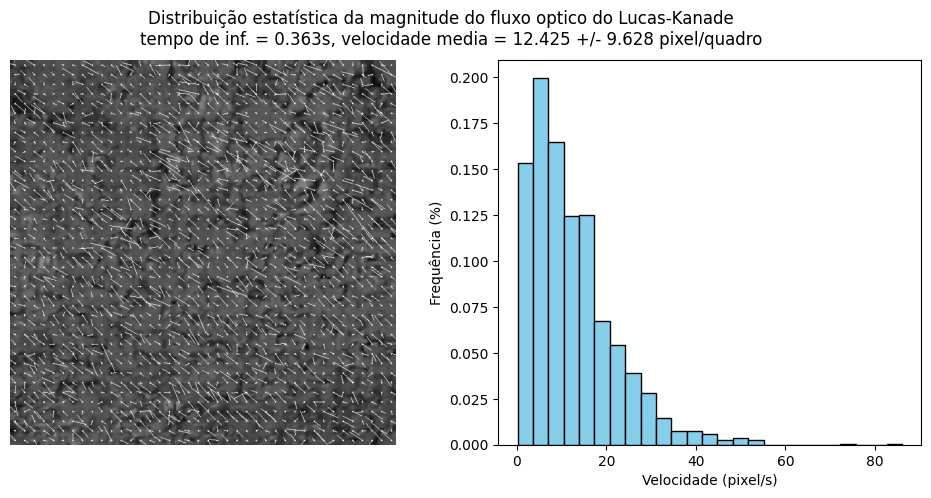

In [469]:
t1 = time.time();
flow = computeLKDenseFlow(drone_prev_gray, drone_curr_gray)
t2 = time.time();

vis = drawFlow(drone_curr_gray, flow, step=16, color=(255,255,0))[:,:,0]
magnitude, _ = cv.cartToPolar(flow[..., 0], flow[..., 1])
distances, edges = np.histogram(magnitude[magnitude > 0], bins=25)
distances = distances / (drone_prev_gray.shape[0]*drone_prev_gray.shape[1])

mean_magnitude = np.mean(magnitude)
std_dev = np.std(magnitude)

fig, axis = plt.subplots(1, 2, figsize=(12, 5))
axis[0].imshow(vis, cmap='gray')
axis[0].axis('off');
axis[1].bar(edges[:-1], distances, width=np.diff(edges), align='edge', color='skyblue', edgecolor='black');
fig.suptitle(f"Distribuição estatística da magnitude do fluxo optico do Lucas-Kanade\n\
    tempo de inf. = {t2 - t1:.3f}s, velocidade media = {mean_magnitude:.3f} +/- {std_dev:.3f} pixel/quadro")
plt.xlabel('Velocidade (pixel/s)')
plt.ylabel('Frequência (%)');
plt.show()

##### Distribuição do fluxo optico Lucas-Kanade + cantos de Shi-Tomasi

In [470]:
def dist(p0, p1):
    p0 = np.array(p0)
    p1 = np.array(p1)
    distances = np.linalg.norm(p1 - p0, axis=1)
    return distances

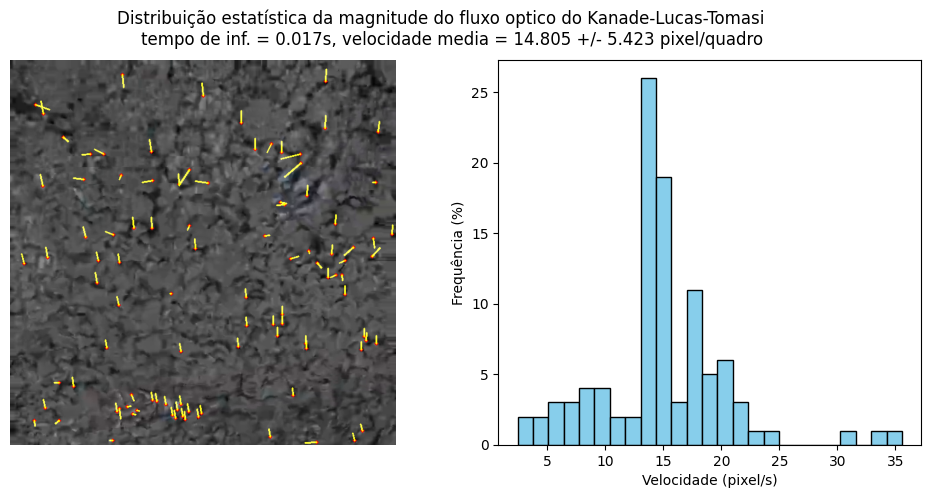

In [472]:
drone_prev = cv.imread('../../data/drone_footage_synthetic_ground/1/frame00096.png')
drone_curr = cv.imread('../../data/drone_footage_synthetic_ground/1/frame00097.png')

drone_prev_gray = cv.cvtColor(drone_prev,cv.COLOR_BGR2GRAY)
drone_curr_gray = cv.cvtColor(drone_curr,cv.COLOR_BGR2GRAY)

t1 = time.time();
p0, p1 = computeKLTOpticalFlow(drone_prev_gray, drone_curr_gray)
t2 = time.time();

mask = np.zeros_like(drone_prev)
for i, (new, old) in enumerate(zip(p1, p0)):
    a, b = new.ravel()
    c, d = old.ravel()
    mask = cv.line(mask, (int(a), int(b)), (int(c), int(d)), (255, 255, 0), 2)
    frame = cv.circle(drone_curr, (int(a), int(b)), 1, (255, 0, 0), 3)
    img = cv.add(frame, mask)
    
magnitude = dist(p0, p1)
distances, edges = np.histogram(magnitude, bins=25)
distances = 100*(distances / len(A))

mean_magnitude = np.mean(magnitude)
std_dev = np.std(magnitude)

fig, axis = plt.subplots(1, 2, figsize=(12, 5))
axis[0].imshow(img, cmap='gray')
axis[0].axis('off');
axis[1].bar(edges[:-1], distances, width=np.diff(edges), align='edge', color='skyblue', edgecolor='black')
fig.suptitle(f"Distribuição estatística da magnitude do fluxo optico do Kanade-Lucas-Tomasi\n\
    tempo de inf. = {t2 - t1:.3f}s, velocidade media = {mean_magnitude:.3f} +/- {std_dev:.3f} pixel/quadro")
plt.xlabel('Velocidade (pixel/s)')
plt.ylabel('Frequência (%)');
plt.show()

##### Distribuição do fluxo optico Lucas-Kanade + cantos de Harris

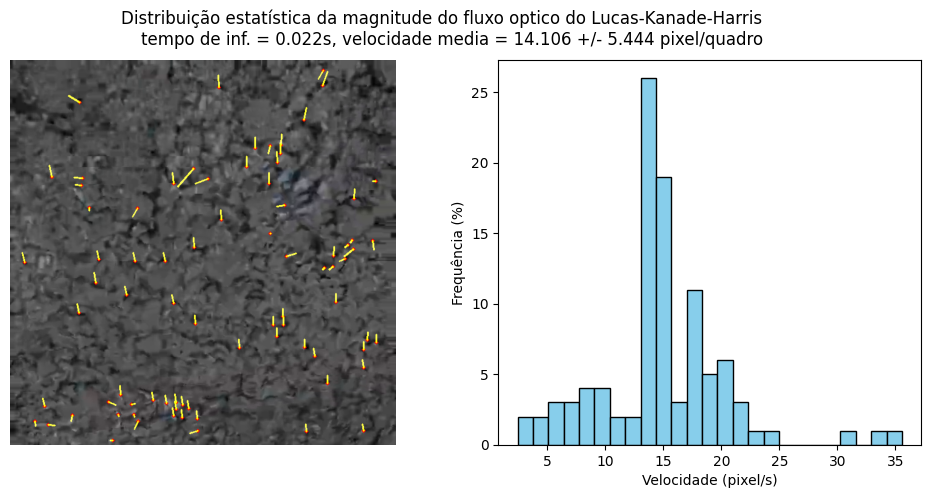

In [473]:
drone_prev = cv.imread('../../data/drone_footage_synthetic_ground/1/frame00096.png')
drone_curr = cv.imread('../../data/drone_footage_synthetic_ground/1/frame00097.png')

drone_prev_gray = cv.cvtColor(drone_prev,cv.COLOR_BGR2GRAY)
drone_curr_gray = cv.cvtColor(drone_curr,cv.COLOR_BGR2GRAY)

t1 = time.time();
p0 = np.float32(cv.cornerHarris(drone_prev_gray, 2, 3, 0.04))
p0 = cv.goodFeaturesToTrack(p0, maxCorners=100, qualityLevel=0.01, minDistance=10)
p0, p1 = computeKLTOpticalFlow(drone_prev, drone_curr, p0=p0)
t2 = time.time();

mask = np.zeros_like(drone_prev)
for i, (new, old) in enumerate(zip(p1, p0)):
    a, b = new.ravel()
    c, d = old.ravel()
    mask = cv.line(mask, (int(a), int(b)), (int(c), int(d)), (255, 255, 0), 2)
    frame = cv.circle(drone_curr, (int(a), int(b)), 1, (255, 0, 0), 3)
    img = cv.add(frame, mask)
    
magnitude = dist(p0, p1)
distances, edges = np.histogram(A, bins=25)
distances = 100*(distances / len(A))

mean_magnitude = np.mean(magnitude)
std_dev = np.std(magnitude)

fig, axis = plt.subplots(1, 2, figsize=(12, 5))
axis[0].imshow(img, cmap='gray')
axis[0].axis('off');
axis[1].bar(edges[:-1], distances, width=np.diff(edges), align='edge', color='skyblue', edgecolor='black')
fig.suptitle(f"Distribuição estatística da magnitude do fluxo optico do Lucas-Kanade-Harris\n\
    tempo de inf. = {t2 - t1:.3f}s, velocidade media = {mean_magnitude:.3f} +/- {std_dev:.3f} pixel/quadro")
plt.xlabel('Velocidade (pixel/s)')
plt.ylabel('Frequência (%)');

##### Distribuição do fluxo optico Lucas-Kanade + cantos SIFT

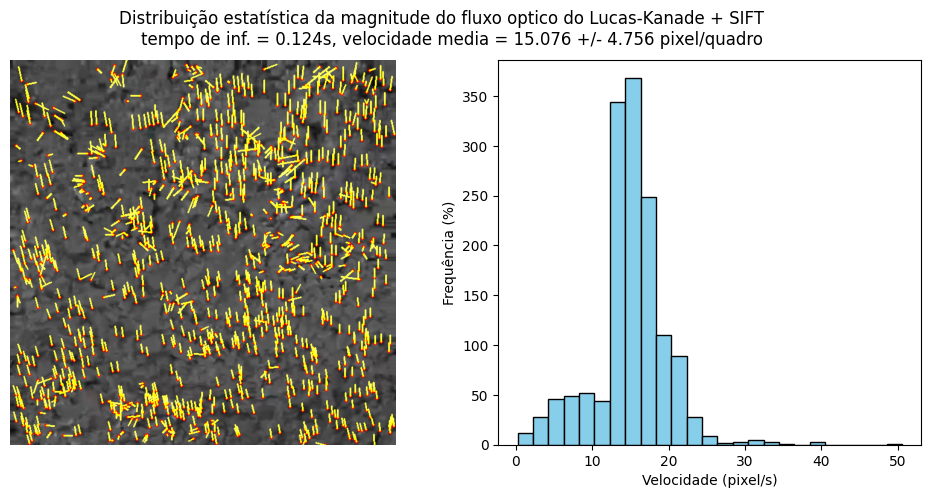

In [474]:
drone_prev = cv.imread('../../data/drone_footage_synthetic_ground/1/frame00096.png')
drone_curr = cv.imread('../../data/drone_footage_synthetic_ground/1/frame00097.png')

drone_prev_gray = cv.cvtColor(drone_prev,cv.COLOR_BGR2GRAY)
drone_curr_gray = cv.cvtColor(drone_curr,cv.COLOR_BGR2GRAY)

t1 = time.time()
sift = cv.SIFT_create()
keypoints = sift.detect(drone_prev_gray,None)
p0 = np.array([kp.pt for kp in keypoints], dtype=np.float32).reshape(-1, 1, 2)
p0, p1 = computeKLTOpticalFlow(drone_prev, drone_curr, p0=p0)
t2 = time.time()

mask = np.zeros_like(drone_prev)
for i, (new, old) in enumerate(zip(p1, p0)):
    a, b = new.ravel()
    c, d = old.ravel()
    mask = cv.line(mask, (int(a), int(b)), (int(c), int(d)), (255, 255, 0), 2)
    frame = cv.circle(drone_curr, (int(a), int(b)), 1, (255, 0, 0), 3)
    img = cv.add(frame, mask)
    
magnitude = dist(p0, p1)
distances, edges = np.histogram(magnitude, bins=25)
distances = 100*(distances / len(A))

mean_magnitude = np.mean(magnitude)
std_dev = np.std(magnitude)

fig, axis = plt.subplots(1, 2, figsize=(12, 5))
axis[0].imshow(img, cmap='gray')
axis[0].axis('off');
axis[1].bar(edges[:-1], distances, width=np.diff(edges), align='edge', color='skyblue', edgecolor='black')
fig.suptitle(f"Distribuição estatística da magnitude do fluxo optico do Lucas-Kanade + SIFT\n\
    tempo de inf. = {t2 - t1:.3f}s, velocidade media = {mean_magnitude:.3f} +/- {std_dev:.3f} pixel/quadro")
plt.xlabel('Velocidade (pixel/s)')
plt.ylabel('Frequência (%)');
plt.show()

##### Distribuição do fluxo optico Lucas-Kanade + cantos FAST

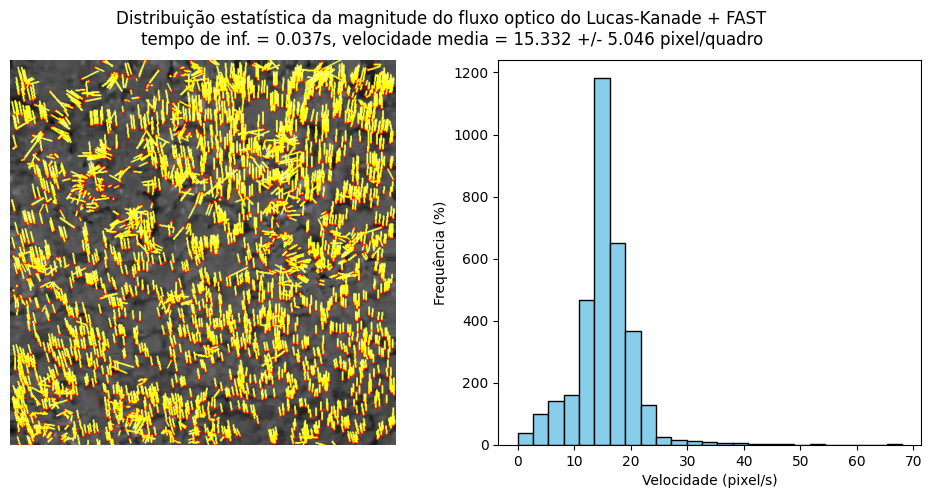

In [476]:
drone_prev = cv.imread('../../data/drone_footage_synthetic_ground/1/frame00096.png')
drone_curr = cv.imread('../../data/drone_footage_synthetic_ground/1/frame00097.png')

drone_prev_gray = cv.cvtColor(drone_prev,cv.COLOR_BGR2GRAY)
drone_curr_gray = cv.cvtColor(drone_curr,cv.COLOR_BGR2GRAY)

t1 = time.time()
fast = cv.FastFeatureDetector_create()
keypoints = fast.detect(drone_prev_gray, None)
p0 = np.array([kp.pt for kp in keypoints], dtype=np.float32).reshape(-1, 1, 2)
p0, p1 = computeKLTOpticalFlow(drone_prev_gray, drone_curr_gray, p0=p0)
t2 = time.time()

mask = np.zeros_like(drone_prev)
for i, (new, old) in enumerate(zip(p1, p0)):
    a, b = new.ravel()
    c, d = old.ravel()
    mask = cv.line(mask, (int(a), int(b)), (int(c), int(d)), (255, 255, 0), 2)
    frame = cv.circle(drone_curr, (int(a), int(b)), 1, (255, 0, 0), 3)
    img = cv.add(frame, mask)
    
magnitude = dist(p0, p1)
distances, edges = np.histogram(magnitude, bins=25)
distances = 100*(distances / len(A))

mean_magnitude = np.mean(magnitude)
std_dev = np.std(magnitude)

fig, axis = plt.subplots(1, 2, figsize=(12, 5))
axis[0].imshow(img, cmap='gray')
axis[0].axis('off');
axis[1].bar(edges[:-1], distances, width=np.diff(edges), align='edge', color='skyblue', edgecolor='black')
fig.suptitle(f"Distribuição estatística da magnitude do fluxo optico do Lucas-Kanade + FAST\n\
    tempo de inf. = {t2 - t1:.3f}s, velocidade media = {mean_magnitude:.3f} +/- {std_dev:.3f} pixel/quadro")
plt.xlabel('Velocidade (pixel/s)')
plt.ylabel('Frequência (%)');
plt.show()

##### Conclusões parciais

Analizou-se a dispersão estatística dos vetores de velocidade. É sabido que essa característica fará mal a estimação de movimento, então buscou-se um método que reduz a dispersão dos vetores. Além disso, como estamos interessados em aplicação de tempo real, a velocidade de inferência deve ser baixa.

O método pela minimização das diferenças mostrou-se o pior, com o maior tempo de inferência e maior dispersão das amostras. Já o método que computa o fluxo optico denso a partir do gradiente de intensidade apresentou menor dispersão em relação ao método das diferenças, mas sendo mais lento que os demais.

Quando analisamos os métodos que utilizam uma janela inicial, percebemos que o tempo de inferência é reduzido drasticamente ao mesmo tempo que a dispersão das amostras é reduzida. Dentre esses, os que apresentaram menor dispersão foram os cantos de SIFT e FAST. Percebeu-se que o FAST estimou um grande número de cantos, sendo que muitos desses não foram corretamente associados ao seu correspondente na imagem posterior, esse comportamento aumenta o erro de estimação de movimento. Nesse aspecto o SIFT mostrou-se mais fidedigno, alimentando o Lucas-Kanade com cantos que foram encontrados corretamente em sua maioria. No entanto, os cantos de Harris e os cantos de Tomasi, ambos apresentaram um custo computacional muito menor, produzindo resultados bem parecidos.

No geral, os cantos de Shi-Tomasi geraram os resultados mais próximos dos métodos mais robustos, mesmo sendo quase dez vezes mais rápido.

In [685]:
def computeFlowHistogram(imgs_path, file_pattern="frame*.png", max_mag_size=100, method="tomasi"):
    file_paths = glob.glob(f'{imgs_path}/{file_pattern}')
    file_paths.sort()
    
    if method == "fast":
        extractor = cv.FastFeatureDetector_create()
    elif method == "sift":
        extractor = cv.SIFT_create()

    prev = cv.imread(file_paths[0])
    prev_gray = cv.cvtColor(prev, cv.COLOR_BGR2GRAY)
    
    mean_vec = []
    std_vec = []
    mag_vec = []
    
    for img_path in file_paths[1:]:
        curr = cv.imread(img_path)
        curr_gray = cv.cvtColor(curr, cv.COLOR_BGR2GRAY)

        if method == "dense":    
            flow = computeLKDenseFlow(prev_gray, curr_gray)
            magnitude, _ = cv.cartToPolar(flow[..., 0], flow[..., 1])
        elif method in ["tomasi", "harris", "sift", "fast"]:
            if method == "harris":
                p0 = np.float32(cv.cornerHarris(prev_gray, 2, 3, 0.04))
                p0 = cv.goodFeaturesToTrack(p0, maxCorners=100, qualityLevel=0.01, minDistance=10)
            elif method == "tomasi":
                p0 = cv.goodFeaturesToTrack(prev_gray, maxCorners=100, qualityLevel=0.01, minDistance=10)
            elif method == "fast" or method == "sift":
                keypoints = extractor.detect(prev_gray,None)
                p0 = np.array([kp.pt for kp in keypoints], dtype=np.float32).reshape(-1, 1, 2)
                
            p0, p1 = computeKLTOpticalFlow(prev_gray, curr_gray, p0=p0)
            magnitude = dist(p0, p1)
            if (len(magnitude) < max_mag_size):
                magnitude = np.pad(magnitude, (0, max_mag_size - len(magnitude)), 'constant')
            elif len(magnitude) > max_mag_size:
                print("error")
                continue

        distances, edges = np.histogram(magnitude, bins=25)
        distances = distances / (prev_gray.shape[0]*curr_gray.shape[1])
        
        mean_vec.append(np.mean(magnitude[magnitude > 0]))
        std_vec.append(np.std(magnitude[magnitude > 0]))
        mag_vec.append(magnitude)
    
        mean_magnitude = np.mean(magnitude)
        std_dev = np.std(magnitude)
    
        prev_gray = curr_gray
    return mag_vec, mean_vec, std_vec

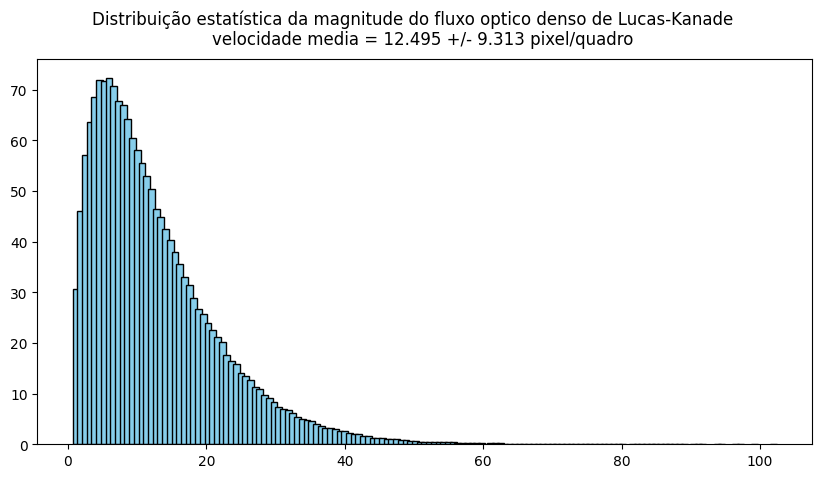

In [772]:
folder_path = '/home/felix/projects/flow/data/drone_footage_synthetic_ground/2'

magv_dense, meanv_dense, stdv_dense = computeFlowHistogram(folder_path, method="dense")

distances, edges = np.histogram(magv_dense, bins=150)
distances = distances / (len(magv_dense)**2)

non_zero_edges = edges[:-1][distances > 0][1:]
non_zero_distances = distances[distances > 0][1:]

plt.rcParams["figure.figsize"] = (10,5)
plt.bar(non_zero_edges, non_zero_distances, align='edge', color='skyblue', edgecolor='black', width=1);
plt.suptitle(f"Distribuição estatística da magnitude do fluxo optico denso de Lucas-Kanade\n\
    velocidade media = {np.mean(meanv_dense):.3f} +/- {np.mean(stdv_dense):.3f} pixel/quadro")
plt.savefig("drone_footage_synthetic_ground_lk_dense.png", dpi=300)

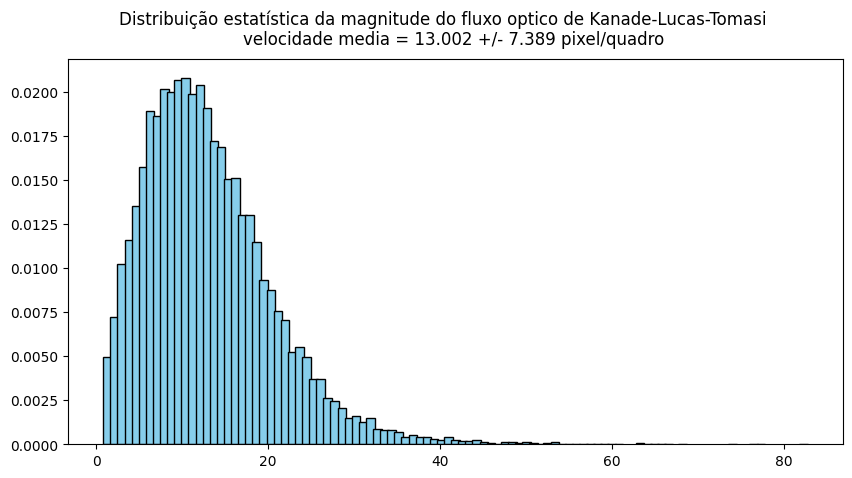

In [773]:
folder_path = '/home/felix/projects/flow/data/drone_footage_synthetic_ground/2'

magv, meanv, stdv = computeFlowHistogram(folder_path, method="tomasi")

distances, edges = np.histogram(magv, bins=100)
distances = distances / (len(magv)**2)

non_zero_edges = edges[:-1][distances > 0][1:]
non_zero_distances = distances[distances > 0][1:]

plt.rcParams["figure.figsize"] = (10,5)
plt.bar(non_zero_edges, non_zero_distances, align='edge', color='skyblue', edgecolor='black', width=1);
plt.suptitle(f"Distribuição estatística da magnitude do fluxo optico de Kanade-Lucas-Tomasi\n\
    velocidade media = {np.mean(meanv):.3f} +/- {np.mean(stdv):.3f} pixel/quadro")
plt.savefig("drone_footage_synthetic_ground_klt.png", dpi=300)

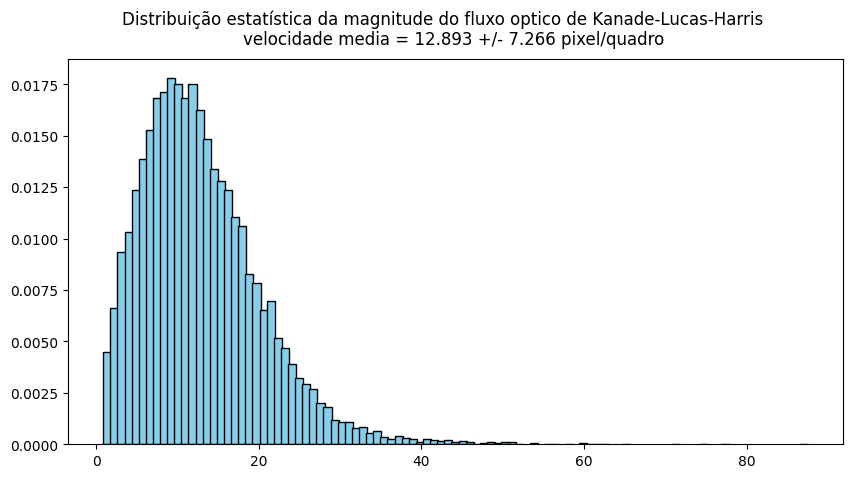

In [774]:
folder_path = '/home/felix/projects/flow/data/drone_footage_synthetic_ground/2'

magv, meanv, stdv = computeFlowHistogram(folder_path, method="harris")

distances, edges = np.histogram(magv, bins=100)
distances = distances / (len(magv)**2)

non_zero_edges = edges[:-1][distances > 0][1:]
non_zero_distances = distances[distances > 0][1:]

plt.rcParams["figure.figsize"] = (10,5)
plt.bar(non_zero_edges, non_zero_distances, align='edge', color='skyblue', edgecolor='black', width=1);
plt.suptitle(f"Distribuição estatística da magnitude do fluxo optico de Kanade-Lucas-Harris\n\
    velocidade media = {np.mean(meanv):.3f} +/- {np.mean(stdv):.3f} pixel/quadro")
plt.savefig("drone_footage_synthetic_ground_lk_harris.png", dpi=300)

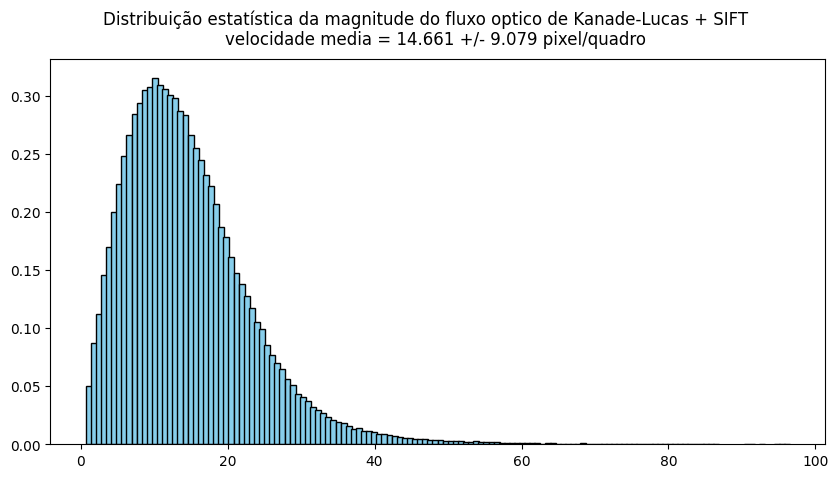

In [775]:
folder_path = '/home/felix/projects/flow/data/drone_footage_synthetic_ground/2'
max_size = 4500
magv, meanv, stdv = computeFlowHistogram(folder_path, method="sift", max_mag_size=max_size)

distances, edges = np.histogram(magv, bins=450)
distances = distances / (len(magv)**2)

non_zero_edges = edges[:-1][distances > 1e-4][1:]
non_zero_distances = distances[distances > 1e-4][1:]

plt.rcParams["figure.figsize"] = (10,5)
plt.bar(non_zero_edges, non_zero_distances, align='edge', color='skyblue', edgecolor='black');
plt.suptitle(f"Distribuição estatística da magnitude do fluxo optico de Kanade-Lucas + SIFT\n\
    velocidade media = {np.mean(meanv):.3f} +/- {np.mean(stdv):.3f} pixel/quadro")
plt.savefig("drone_footage_synthetic_ground_lk_sift.png", dpi=300)

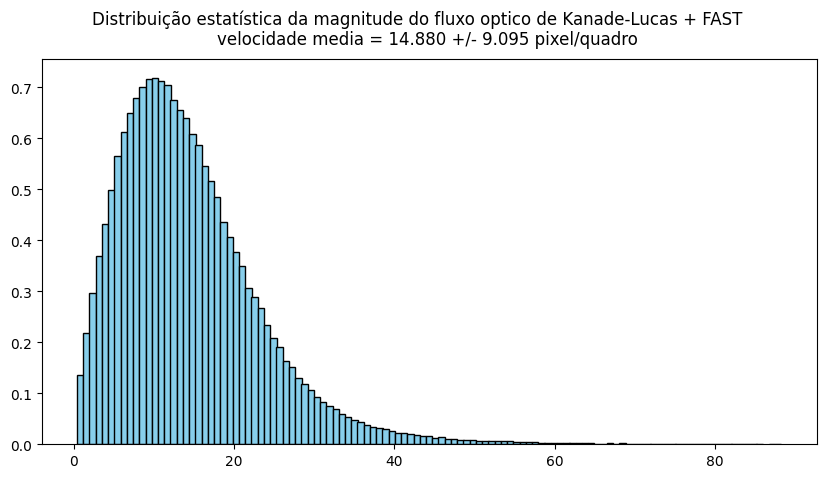

In [776]:
folder_path = '/home/felix/projects/flow/data/drone_footage_synthetic_ground/2'

max_size = 7500
magv, meanv, stdv = computeFlowHistogram(folder_path, method="fast", max_mag_size=7500)

distances, edges = np.histogram(magv, bins=200)
distances = distances / (len(magv)**2)

non_zero_edges = edges[:-1][distances > 2e-4][1:]
non_zero_distances = distances[distances > 2e-4][1:]

plt.rcParams["figure.figsize"] = (10,5)
plt.bar(non_zero_edges, non_zero_distances, align='center', color='skyblue', edgecolor='black');
plt.suptitle(f"Distribuição estatística da magnitude do fluxo optico de Kanade-Lucas + FAST\n\
    velocidade media = {np.mean(meanv):.3f} +/- {np.mean(stdv):.3f} pixel/quadro")
plt.savefig("drone_footage_synthetic_ground_lk_fast.png", dpi=300)